# Maritime Vessel Classification using AIS Data
This notebook is for the ML Project, Kabita & Debayan

In [ ]:
# Importing the libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas as pd
import numpy as np
from typing import Any, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb



# Set style for the plots
sns.set(style='darkgrid')

In [ ]:

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Save data to a file (e.g., a DataFrame to CSV)
df =pd.read_csv('/content/drive/MyDrive/ais_data_Kattegat_Strait.csv',index_col=False)

Mounted at /content/drive


In [ ]:
display(df.head())
display(df.tail())

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
358346,387577,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2
358347,387578,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9
358348,387579,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9
358349,387580,219007697,Unknown value,34.9,96.2,NaN,Pilot,3.0,7.0,NaN
358350,387581,261054050,Under way using engine,11.5,315.0,310.0,Fishing,8.0,32.0,6.0


We are dropping the first column as it is clear it was created when resetting index, or saving csv without removing it.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358351 entries, 0 to 358350
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          358351 non-null  int64  
 1   mmsi                358351 non-null  int64  
 2   navigationalstatus  358351 non-null  object 
 3   sog                 357893 non-null  float64
 4   cog                 355182 non-null  float64
 5   heading             337737 non-null  float64
 6   shiptype            358351 non-null  object 
 7   width               354640 non-null  float64
 8   length              354608 non-null  float64
 9   draught             332808 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 27.3+ MB


In [ ]:
df = df.iloc[:,1:]

In [ ]:
df.drop(['mmsi'], axis=1).describe()

,sog,cog,heading,width,length,draught
count,357893.000000,355182.000000,337737.000000,354640.000000,354608.000000,332808.000000
mean,12.122554,189.064529,190.076829,19.947854,124.971549,6.571402
std,9.355851,107.588825,107.107604,10.808627,71.268183,2.934392
min,0.000000,0.000000,0.000000,1.000000,2.000000,0.400000
25%,9.200000,116.300000,120.000000,12.000000,83.000000,4.600000
50%,11.300000,168.700000,170.000000,17.000000,115.000000,6.100000
75%,13.300000,300.175000,303.000000,28.000000,181.000000,7.900000
max,214.000000,359.900000,507.000000,78.000000,690.000000,25.500000


From the table shown above, it is clear that their are some clear outliers with sog, length and draught


Having both width and length allows us to add an additional variable (area), with the only caveat being that the length and width were likely taken at the maximum points

In [ ]:
df['area'] = df.width * df.length

Missing Values count in each columns

In [ ]:
pd.DataFrame(df.isna().sum())

,0
mmsi,0
navigationalstatus,0
sog,458
cog,3169
heading,20614
shiptype,0
width,3711
length,3743
draught,25543
area,3773


In [ ]:
print(f"Proportion of null value rows: {round(len(df[df.isnull().any(axis=1)]) / len(df)*100)}%")

Proportion of null value rows: 9%


Null values account for approximately 9% of the data. A high proportion of missing values in the static variables. So, providing we have this information for the same vessels from another journey, then we can imput these values.

In [ ]:
static_vars = ['length', 'width', 'draught', 'area']

for var in static_vars:
    df[var] = df[['mmsi', var]].groupby('mmsi').transform(lambda x: x.fillna(x.median()))

With this imputation, we have been able to fill a good amount of the ships dimensions variables.

We also include navigational status Unknown values within this as these have been logged as a string opposed to null values. Although we may not remove them, it is good to understand the quantity.

In [ ]:
pd.DataFrame(df.navigationalstatus.value_counts())

,navigationalstatus
Under way using engine,307581
Unknown value,17259
Constrained by her draught,12287
Engaged in fishing,10798
Moored,4121
Reserved for future amendment [HSC],1872
Restricted maneuverability,1868
Under way sailing,1396
At anchor,513
Power-driven vessel towing astern,377


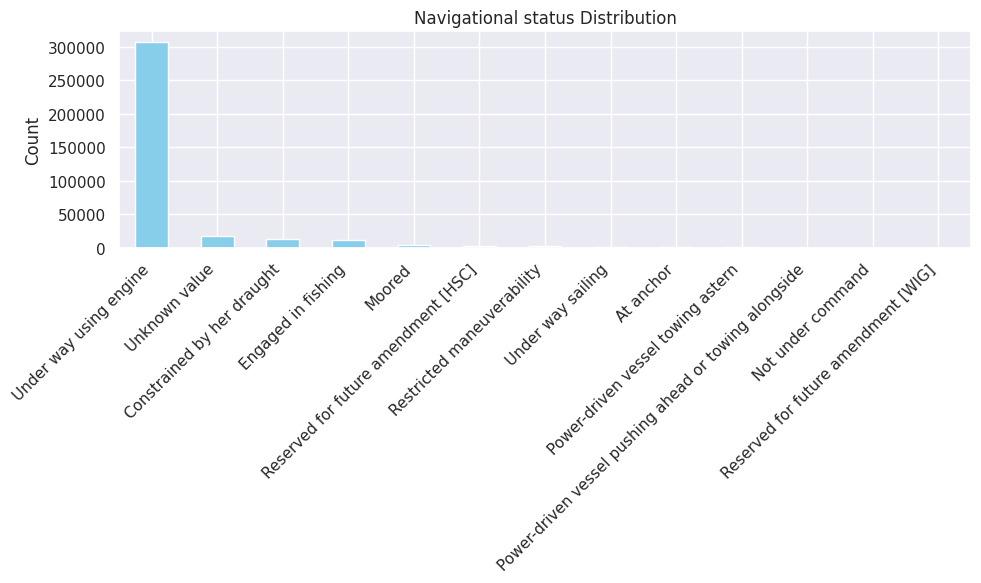

In [ ]:
navigationalstatus_counts = df['navigationalstatus'].value_counts()

plt.figure(figsize=(10, 6))
navigationalstatus_counts.plot(kind='bar', color='skyblue')
plt.title('Navigational status Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
df

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN,36.0
1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN,216.0
2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN,44.0
3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN,36.0
4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3,1287.0
...,...,...,...,...,...,...,...,...,...,...
358346,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2,984.0
358347,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9,4590.0
358348,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9,8064.0
358349,219007697,Unknown value,34.9,96.2,NaN,Pilot,3.0,7.0,NaN,21.0


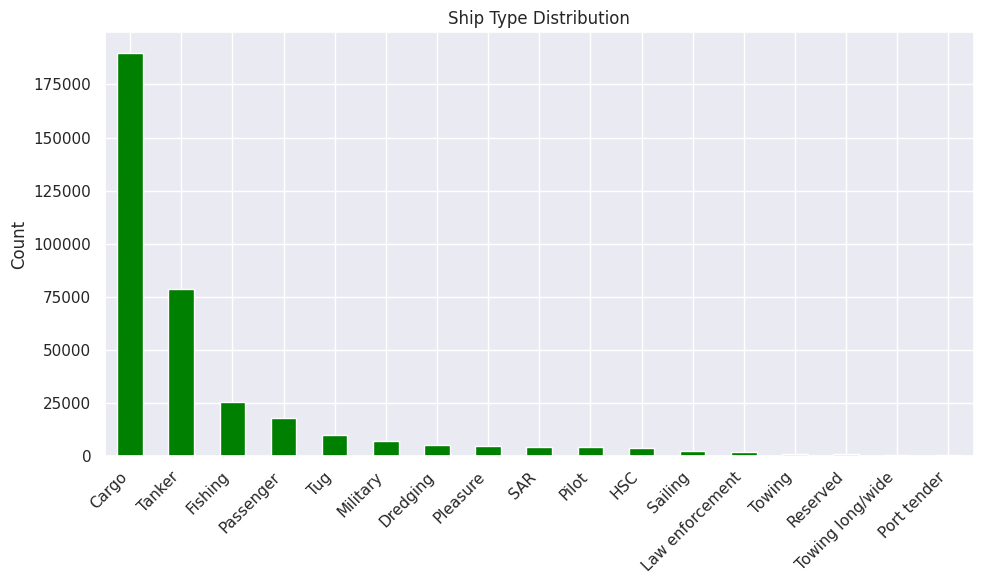

In [ ]:
ship_type_counts = df['shiptype'].value_counts()

plt.figure(figsize=(10, 6))
ship_type_counts.plot(kind='bar', color='green')
plt.title('Ship Type Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Check to see how the missing values are split between the ship types as a proportion.
missing_ship_count = pd.DataFrame(df[df.isnull().any(axis=1)].shiptype.value_counts()).reset_index()

In [ ]:
missing_ship_count.head(20)

,index,shiptype
0,Fishing,13360
1,Pleasure,4461
2,SAR,3841
3,Sailing,2392
4,Cargo,1788
5,Pilot,1145
6,Military,1122
7,Passenger,885
8,Tug,645
9,Dredging,271


In [ ]:
ship_count = pd.DataFrame(df.shiptype.value_counts()).reset_index()

In [ ]:
ship_count

,index,shiptype
0,Cargo,190027
1,Tanker,78535
2,Fishing,25481
3,Passenger,17825
4,Tug,10112
5,Military,7239
6,Dredging,5432
7,Pleasure,4538
8,SAR,4349
9,Pilot,4047


In [ ]:
missing_ship_count = missing_ship_count.merge(ship_count, on='index', how='left')

In [ ]:
missing_ship_count

,index,shiptype_x,shiptype_y
0,Fishing,13360,25481
1,Pleasure,4461,4538
2,SAR,3841,4349
3,Sailing,2392,2549
4,Cargo,1788,190027
5,Pilot,1145,4047
6,Military,1122,7239
7,Passenger,885,17825
8,Tug,645,10112
9,Dredging,271,5432


In [ ]:
# Renaming columns
new_column_names = {'index': 'shiptype', 'shiptype_x': 'count_x', 'shiptype_y': 'count_y'}
missing_ship_count.rename(columns=new_column_names, inplace=True)

In [ ]:
missing_ship_count

,shiptype,count_x,count_y
0,Fishing,13360,25481
1,Pleasure,4461,4538
2,SAR,3841,4349
3,Sailing,2392,2549
4,Cargo,1788,190027
5,Pilot,1145,4047
6,Military,1122,7239
7,Passenger,885,17825
8,Tug,645,10112
9,Dredging,271,5432


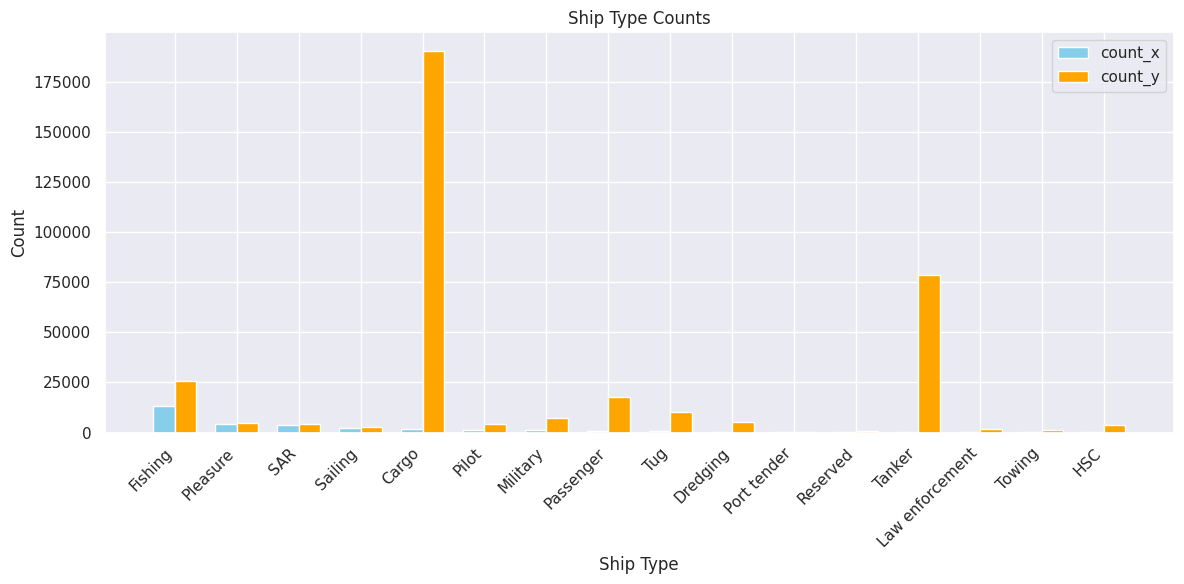

In [ ]:

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for count_x
bar_width = 0.35
bar_positions_x = np.arange(len(missing_ship_count['shiptype']))
ax.bar(bar_positions_x - bar_width/2, missing_ship_count['count_x'], bar_width, label='count_x', color='skyblue')

# Bar plot for count_y
ax.bar(bar_positions_x + bar_width/2, missing_ship_count['count_y'], bar_width, label='count_y', color='orange')

ax.set_title('Ship Type Counts')
ax.set_xlabel('Ship Type')
ax.set_ylabel('Count')
ax.legend()
ax.set_xticks(bar_positions_x)
ax.set_xticklabels(missing_ship_count['shiptype'], rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [ ]:

missing_ship_count['count_after_dropping'] = missing_ship_count.count_y - missing_ship_count.count_x
missing_ship_count['proportion_missing'] = missing_ship_count.count_x/missing_ship_count.count_y

missing_ship_count = missing_ship_count.rename(columns={'count_x':'count_null', 'count_y': 'count'})

missing_ship_count.sort_values(by='proportion_missing', ascending=False)

,shiptype,count_null,count,count_after_dropping,proportion_missing
1,Pleasure,4461,4538,77,0.983032
3,Sailing,2392,2549,157,0.938407
2,SAR,3841,4349,508,0.883192
10,Port tender,259,312,53,0.830128
0,Fishing,13360,25481,12121,0.524312
5,Pilot,1145,4047,2902,0.282926
11,Reserved,184,823,639,0.223572
6,Military,1122,7239,6117,0.154994
14,Towing,147,1034,887,0.142166
13,Law enforcement,171,1688,1517,0.101303


According to the above table, we could think about eliminating the ship types Pleasure and Port tender because they have a large percentage of missing data points and a small number of data points once null values are eliminated. It can also be noted that when taking into account cross-validation and deleting some of these to be included in a serving set for secondary validation, this would be further decreased. It will be crucial to include the warning that forecasts produced on certain ship types should be treated with caution owing to the small quantity of data points, should we decide to retain these variables.

There is a noticeable imbalance in the courses as well, so this will need to be taken into account when choosing the performance metric as well as training the model(s)

In [ ]:
# Drop nulls
df = df.dropna()

Checking duplicates

In [ ]:
print(f"Number of rows with identical values in all variables: {len(df[df.duplicated()])}")

Number of rows with identical values in all variables: 2904



It seems there are quite a high proportion of duplicate rows. Lets see if these duplicates or just different ships with identical values?

In [ ]:
display(df[df.duplicated(keep='first')].sort_values(by=list(df.columns)))

pd.DataFrame(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).shiptype.value_counts())

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
71351,205688000,Under way using engine,9.8,221.0,220.0,Cargo,12.0,83.0,5.0,996.0
227087,205770000,Under way using engine,14.0,34.0,34.0,Tanker,17.0,97.0,5.1,1649.0
128138,209114000,Moored,0.0,291.6,282.0,Cargo,12.0,89.0,4.3,1068.0
255843,209114000,Under way using engine,7.0,165.1,163.0,Cargo,12.0,89.0,4.6,1068.0
116931,209114000,Under way using engine,8.2,325.1,325.0,Cargo,12.0,89.0,4.3,1068.0
...,...,...,...,...,...,...,...,...,...,...
1429,664288000,Under way using engine,15.3,340.0,340.0,Tanker,28.0,185.0,10.5,5180.0
32543,664445000,Under way using engine,12.3,34.5,35.0,Tanker,32.0,189.0,9.5,6048.0
33530,664445000,Under way using engine,12.5,339.4,339.0,Tanker,32.0,189.0,9.5,6048.0
184528,664445000,Under way using engine,14.0,24.5,25.0,Tanker,32.0,189.0,10.7,6048.0


,shiptype
Cargo,3025
Tanker,1894
Passenger,311
Tug,100
Dredging,97
Military,74
HSC,69
SAR,38
Fishing,22
Reserved,9


Regarding whatever variables may account for these repetitions, nothing immediately stands out. To prevent inflating the accuracy of the model(s) erroneously, if there are genuine duplications compared to similar ships, they are eliminated from the data.


In [ ]:
df = df.drop_duplicates()

In [ ]:
len(df)

324561

EDA

In [ ]:
print(f"Number of unique vessels: {df.mmsi.nunique()}")

Number of unique vessels: 2799


Although we have a large number of rows, the actual number of unique vessels is 2799. For the modelling, we have 2 measures by which are:

1. Group by mmsi and then create aggregated variables, or
2. Use grouped k fold when validating (ensuring that the same mmsi id is not in both train and test).

We can test which option will be the most appropriate by seeing if the dynamic variables vary much for each vessel (mmsi)

In [ ]:
dynamic_vars = ['mmsi', 'sog', 'cog', 'heading']

df[dynamic_vars].groupby('mmsi').agg(
    sog_std = ('sog', 'std'),
    cog_std = ('cog', 'std'),
    heading_std = ('heading', 'std'),
).dropna()

,sog_std,cog_std,heading_std
mmsi,,,
205104000,1.785275,110.797995,110.102214
205209000,2.267307,120.775293,119.890407
205211000,2.554713,119.040468,119.216727
205212000,2.896524,117.348181,121.299998
205465000,1.545513,116.815861,130.592347
...,...,...,...
657246900,1.208701,52.226815,46.098415
664288000,1.316891,123.733167,123.701049
664444000,1.496389,113.060527,113.282904


We can see from the above table that there is variation and therefore we should choose the second option (keep all the rows and use grouped k fold) and have the model learn from this higher resolution data. However, the model training process will take signficantly longer due to the large number of data points.

Analysis into the outliers

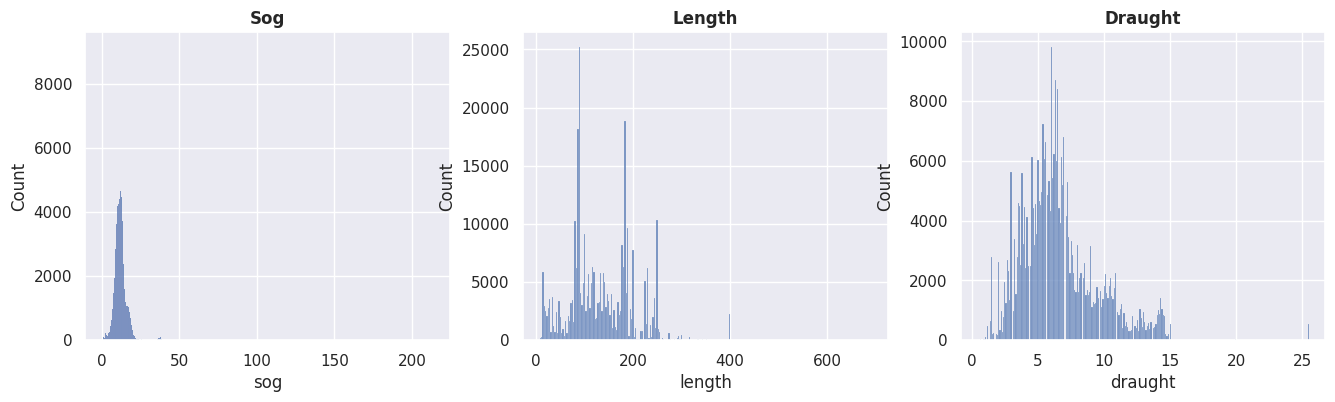

In [ ]:
outlier_cols = ['sog', 'length', 'draught']

fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, col in enumerate(outlier_cols):
    ax1 = sns.histplot(df[col], ax=axes[i])
    ax1.set_title(col.capitalize(), weight='bold')

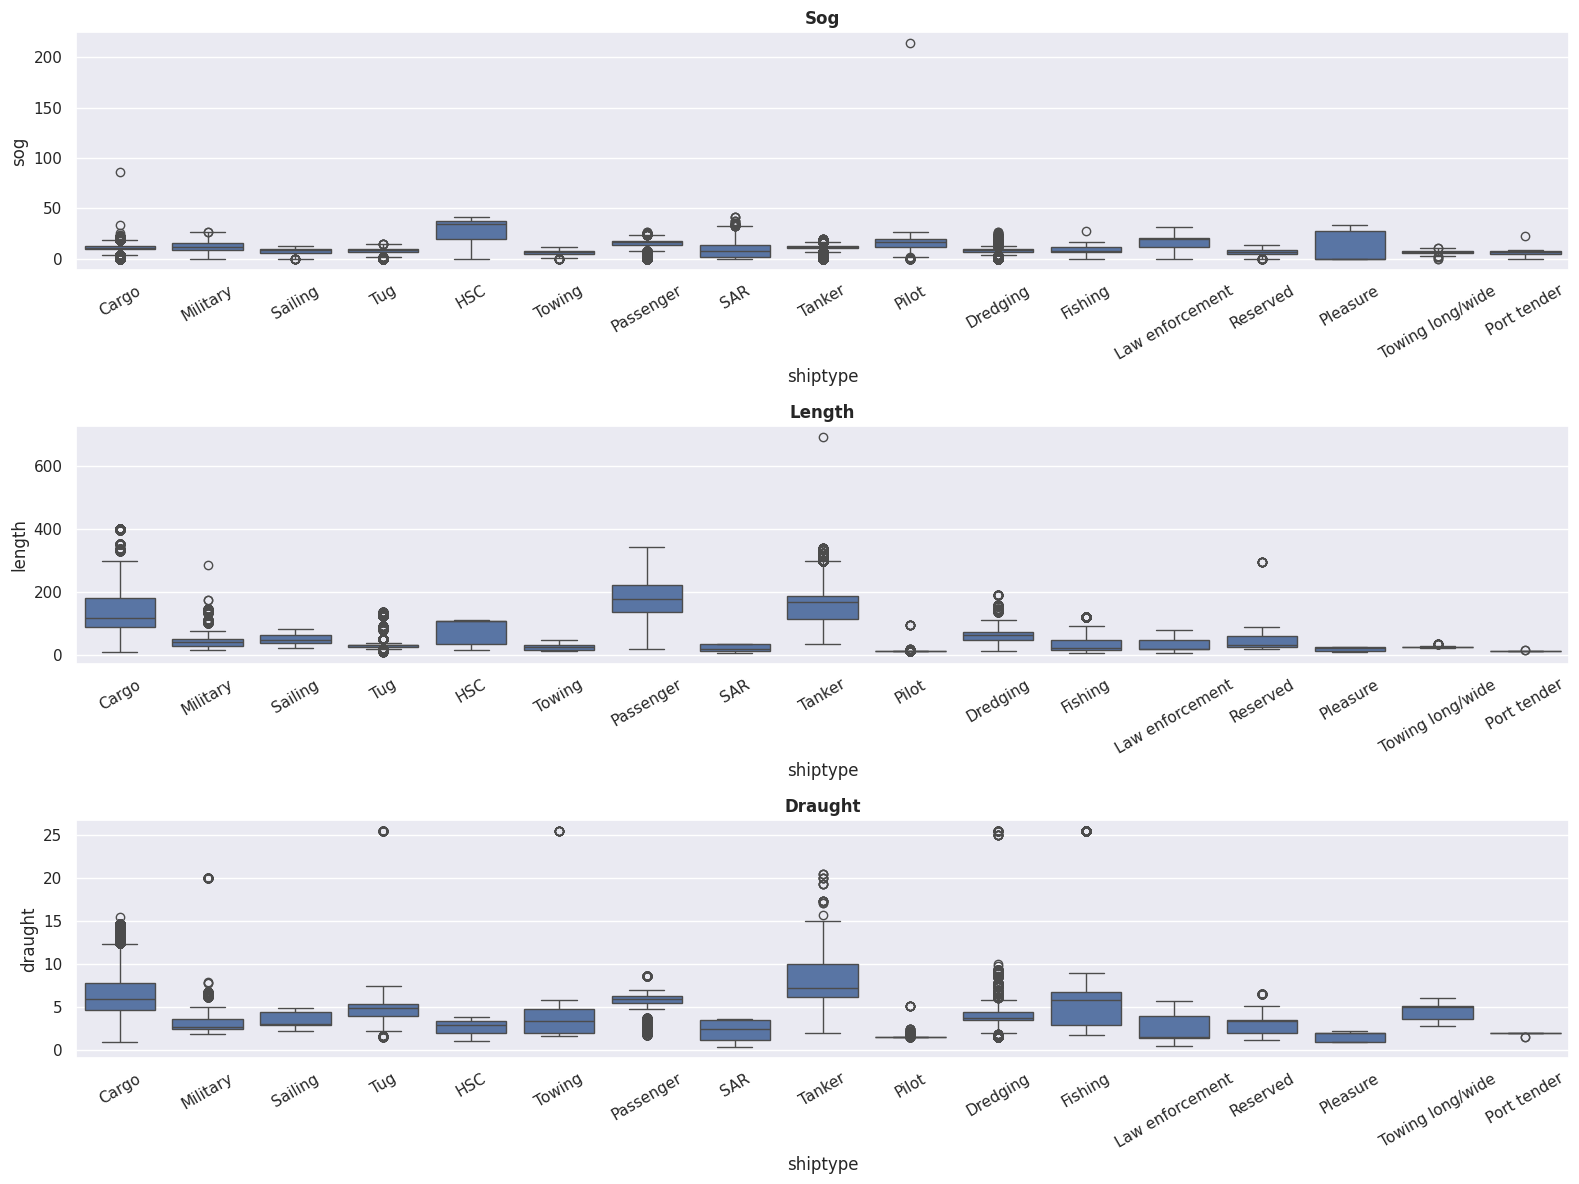

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

In [ ]:
# Potential rows to remove
df[(df.sog>200)|(df.length>500)]

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
76551,211422510,Under way using engine,13.9,134.5,133.0,Tanker,28.0,690.0,6.8,19320.0
330195,219023648,Under way using engine,214.0,343.7,356.0,Pilot,5.0,15.0,1.5,75.0


The boxplots above show a few significant outliers for each of the three variables.

The Pilot ship type's speed over ground of more than 200 knots is one of the (what seems to be) obvious errors. Furthermore, the tanker length of 690 seems to be a mistake, assuming the numbers are in meters. According to research, the largest tanker ever built measured about 458 meters.
Determining what are errors and what are true values would be challenging.In the former case, the model would gain noise. Certain models, including ensemble approaches, are more resilient to outliers, though.
Dropping values of length >500 and sog > 200 was decided.
Furthermore, it is seen that there are significant variations in the distribution of these variable values among the various types of ships, indicating a significant impact on the model's performance.

In [ ]:
df = df[(df.sog<=200)|(df.length<=500)]

Redo the above plot with adjusted y limit in order to visualise better

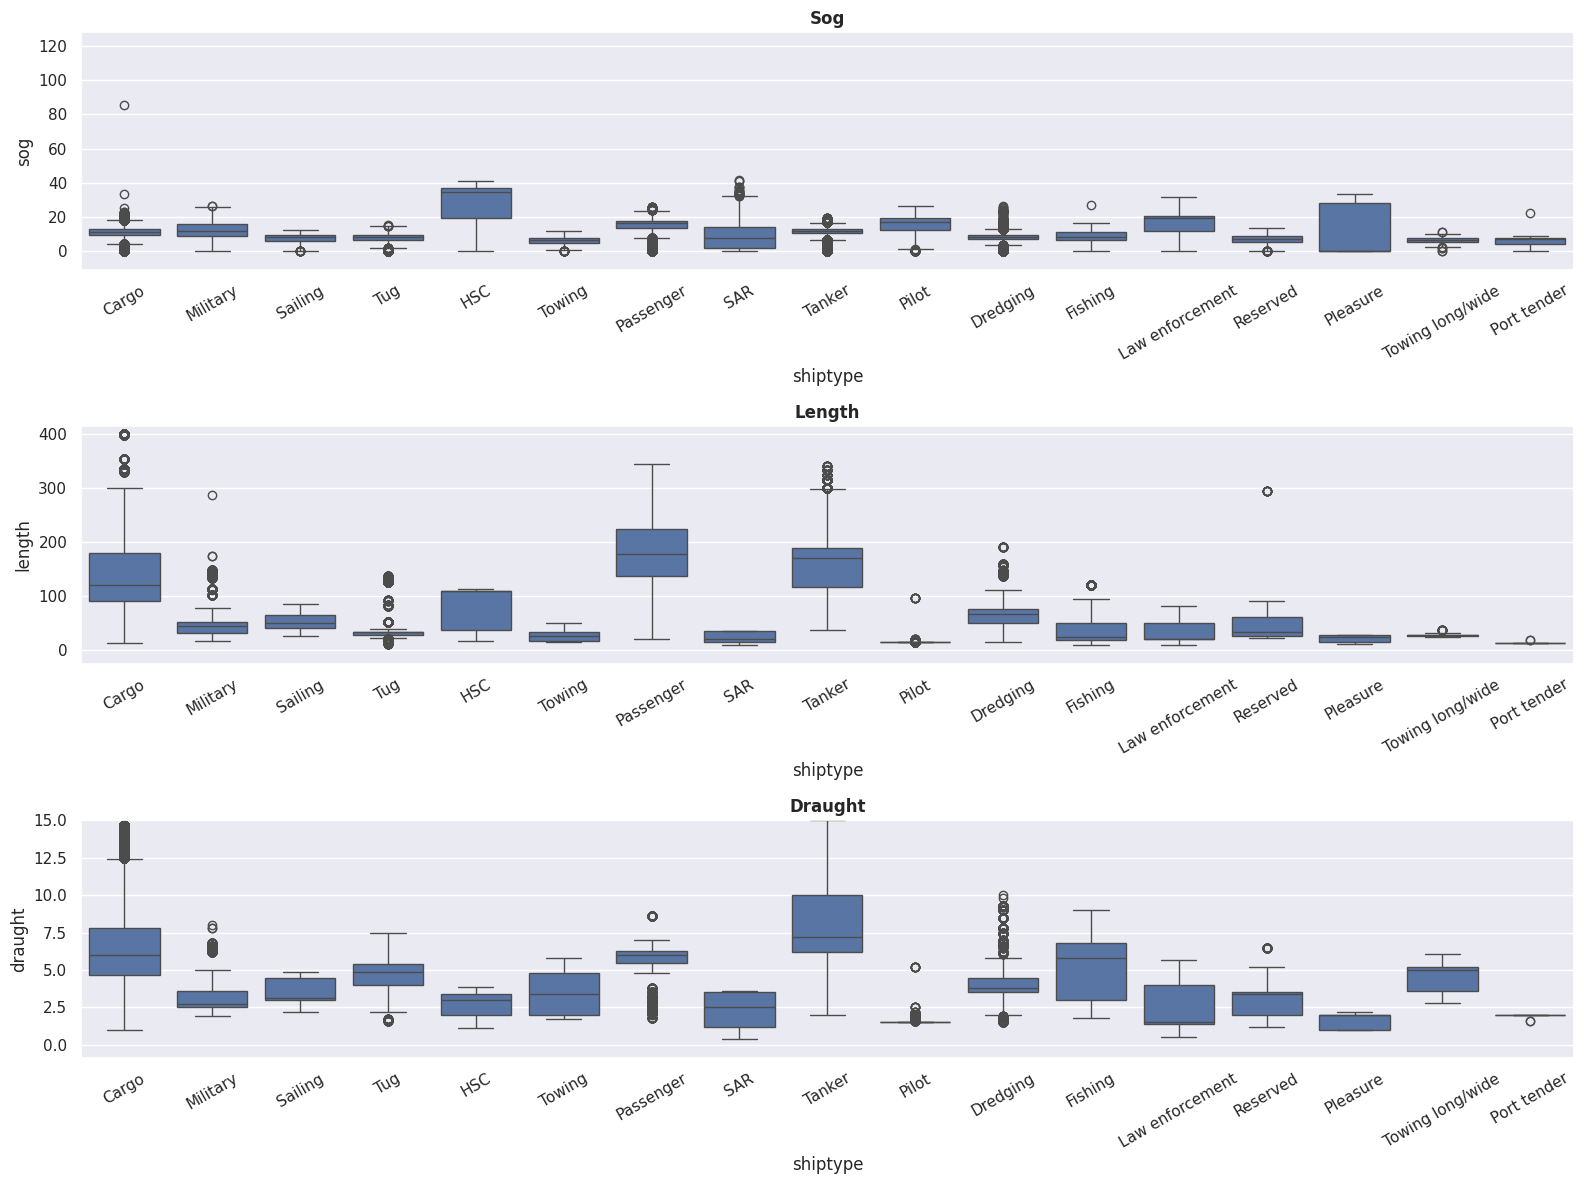

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    ax.set_ylim(top=int(df[col].max()*.6))
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

Now that the y axis has been adjusted we can clearly see the variation between ships for each of the variables. Observations are as follows:

Sog: Without suprise, the HSC has the highest values in SOG.
Length: We can see that length appears to be a clear idendentifier of shiptype, especially in the larger ones such as Cargo, Passenger, and Tanker.
Draught: Again, some clear variations between shiptypes with Carco, Passenger, and Tankr having the higher values


Checking distribution of shiptypes by navigational status.


There is only one column (navigational status) that is of a categorical data type and therefore needs to be encoded (likely one-hot encoding). As there are 13 unique values, it is important to check if there is enough representation of ship types between these groups, as well as seeing if we can see any trends within them.

In [ ]:
pd.DataFrame(df.groupby(['navigationalstatus', 'shiptype']).size()).head(60)

0
navigationalstatus                                 shiptype              
At anchor                                          Cargo              227
                                                   Dredging             9
                                                   Fishing              7
                                                   Law enforcement      1
                                                   Military             7
                                                   Reserved            24
                                                   SAR                  1
                                                   Tanker             212
                                                   Towing              14
                                                   Tug                  5
Constrained by her draught                         Cargo             5228
                                                   Dredging            27
                                                   Reserved            25
                                                   Tanker            6779
Engaged in fishing                                 Dredging             1
                                                   Fishing           5370
Moored                                             Cargo             1087
                                                   Dredging            88
                                                   Fishing            148
                                                   HSC                138
                                                   Law enforcement     21
                                                   Military           412
                                                   Passenger          221
                                                   Pilot               92
                                                   Pleasure            46
                                                   Port tender         52
                                                   Reserved            51
                                                   SAR                125
                                                   Sailing             14
                                                   Tanker             362
                                                   Towing              30
                                                   Towing long/wide     2
                                                   Tug                333
Not under command                                  Cargo                1
                                                   Military             1
                                                   Passenger            1
                                                   Tanker               1
                                                   Tug                  1
Power-driven vessel pushing ahead or towing alo... Cargo                1
                                                   Tug                234
Power-driven vessel towing astern                  Tug                246
Reserved for future amendment [HSC]                Fishing             87
                                                   HSC               1644
Restricted maneuverability                         Cargo                6
                                                   Dredging           181
                                                   Law enforcement     12
                                                   Military            18
                                                   Pilot                4
                                                   Reserved            72
                                                   SAR                  1
                                                   Towing             290
                                                   Towing long/wide   340
                                                   Tug                743
Un

Analysis into the remaining variables

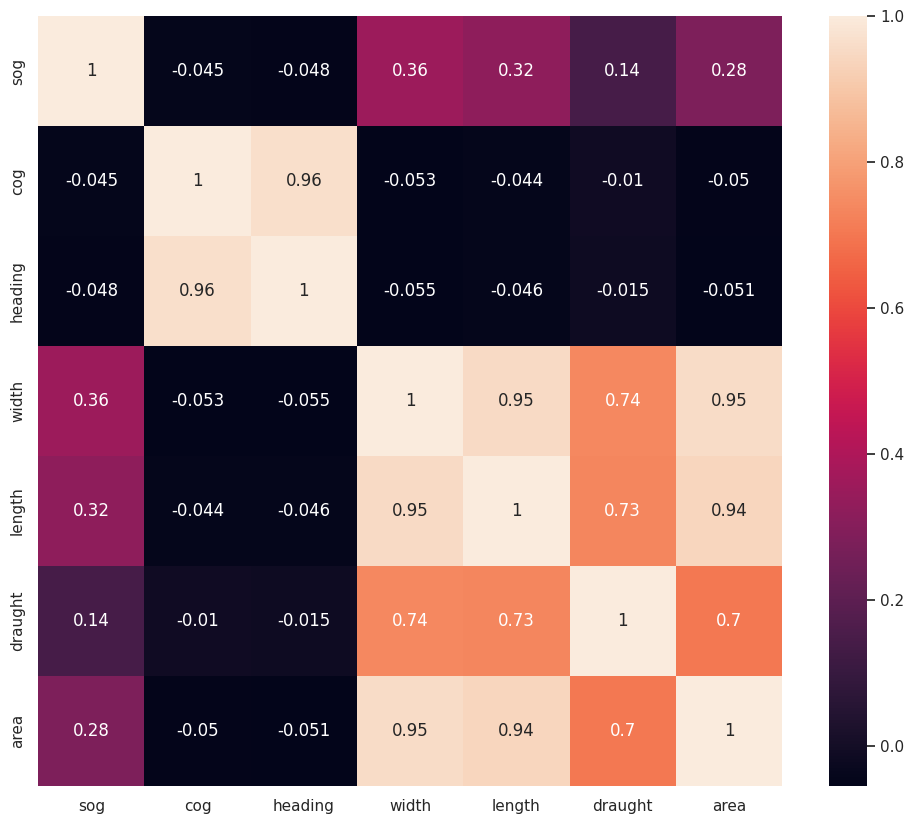

In [ ]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()[1:]

plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr(), annot=True)
plt.show()

There were a few notable, strong, and predictable connections among the continuous variables, including:

Length, width, and area
Draught against width, length and area
Cog and heading

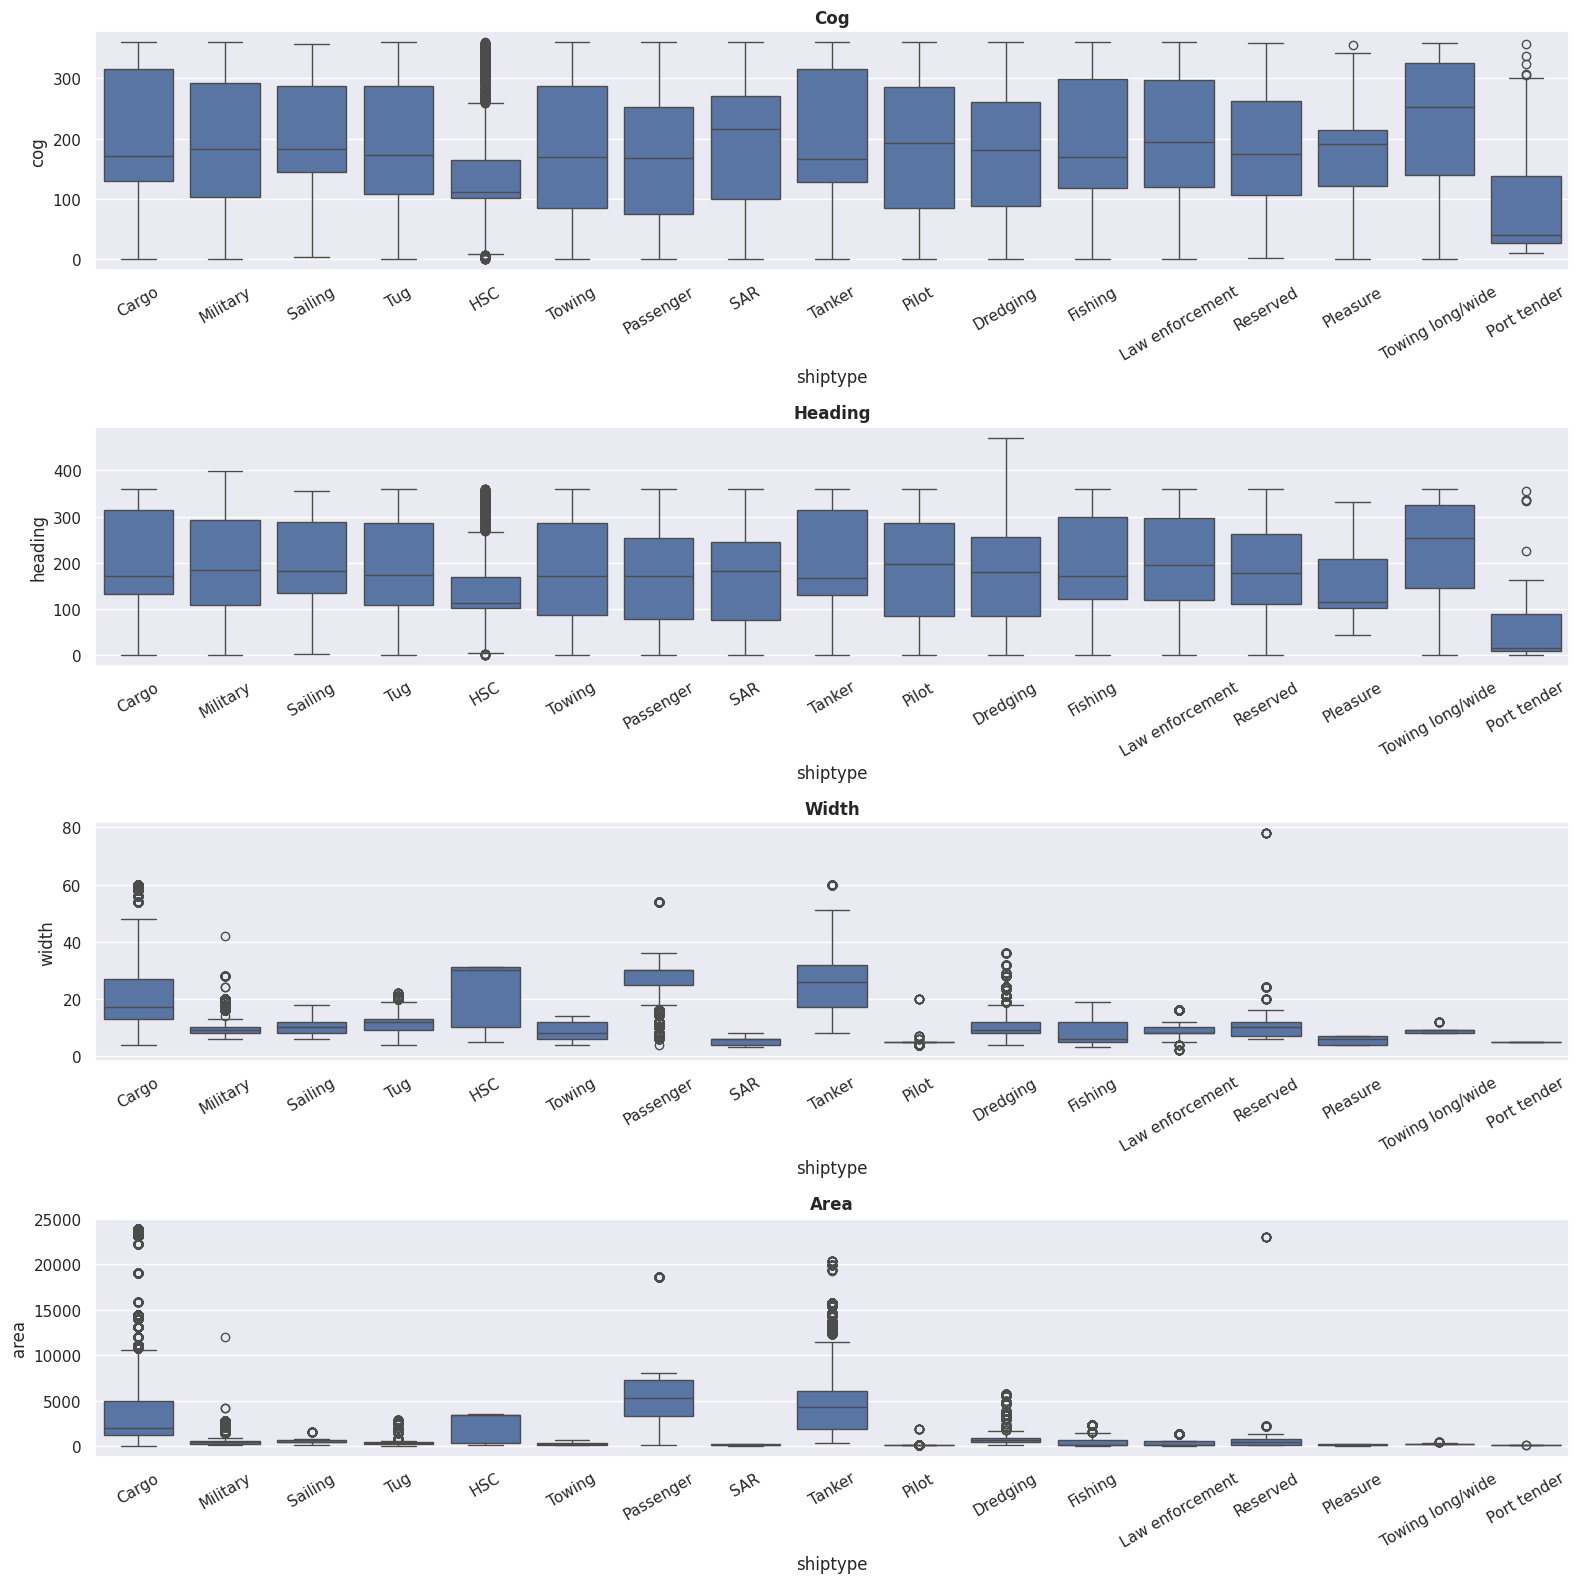

In [ ]:
remaining_vars = ['cog', 'heading', 'width', 'area']

fig, axes = plt.subplots(4, 1, figsize=(16,16))


for i, col in enumerate(remaining_vars):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

The graphs above make it clear that width will be a significant factor for the model or models, despite the fact that the fishing and pleasure ship types have some obvious outliers. With a median that does not appear to fluctuate much, Cog seems to have the least instability among ship types; in contrast, variations in the IQR indicate higher variability.


Model selection

Balanced accuracy is going to be the performance metric utilized to adjust and verify the models. When the response variable classes are unbalanced, the measure provides a more accurate picture of the model's performance. For instance, the accuracy would be almost 60% if the model chose to forecast that every ship would be carrying cargo, which would be an incorrect assessment of the model's performance.

The steps in choosing the best model will be as follows:
Using the default hyperparameters to train multiple classifiers.
Using 5-fold cross validation, choose the best model or models (based on the outcomes).
Adjust the hyperparameters of the model or models that perform the best.
Choose the optimal hyperparameter combination. Test the model on the serving set and retrain using the training set. Note: Since this serving set was totally excluded from the tuning process and most closely resembles a real-world scenario, it is crucial that we validate using it as well.



In [ ]:
df.shiptype

4             Cargo
5             Cargo
7             Cargo
8             Cargo
11         Military
            ...    
358345       Tanker
358346        Cargo
358347        Cargo
358348    Passenger
358350      Fishing
Name: shiptype, Length: 324561, dtype: object

In [ ]:
# Define the resposne variable
response = 'shiptype'

# One-hot encode the categorical columns
cat_col = ['navigationalstatus']
dummies = pd.get_dummies(df[cat_col], dtype=int)
processed_df = pd.concat([df, dummies], axis=1).drop(cat_col, axis=1)

# Rename column with non-standard characters
processed_df = processed_df.rename(columns={'navigationalstatus_Reserved for future amendment [HSC]':'navigationalstatus_Reserved for future amendment'})

In [ ]:
# Serving set to be kept completely left out of the cross validation and model tuning process to bee used as final validation.
np.random.seed(1)
mmsi_validation = np.random.choice(processed_df.mmsi.unique(), int(len(processed_df.mmsi.unique())*.1))

# Scale data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(processed_df.drop([response, 'mmsi'], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns=processed_df.drop([response, 'mmsi'], axis=1).columns)
scaled_df = pd.concat([scaled_df, processed_df[[response, 'mmsi']].reset_index(drop=True)], axis=1)

# Encode the response variable
encoder = LabelEncoder()
scaled_df['shiptype_encode'] = encoder.fit_transform(scaled_df[response])

# Split training and serving df
serving_df = scaled_df[scaled_df.mmsi.isin(mmsi_validation)]
train_df = scaled_df[~scaled_df.mmsi.isin(mmsi_validation)]

In [ ]:
# Check we have representation between the classes
serving_df.shiptype.value_counts()

Cargo               21876
Tanker               9310
Fishing               708
Dredging              673
Military              523
Pilot                 480
Passenger             271
Tug                   115
HSC                    82
Sailing                15
Towing long/wide        1
Name: shiptype, dtype: int64

In [ ]:
serving_df.shiptype_encode.value_counts()

0     21876
13     9310
2       708
1       673
5       523
7       480
6       271
16      115
3        82
12       15
15        1
Name: shiptype_encode, dtype: int64

In [ ]:
response = 'shiptype_encode'
drop_cols = [response, 'mmsi', 'shiptype']

X = train_df.drop(drop_cols, axis=1)
y = train_df[response]

X_serving = serving_df.drop(drop_cols, axis=1)
y_serving = serving_df[response]

Shortlist best model(s) - single split, out of box hyperparameters

In [ ]:
## Split train and test
np.random.seed(1)
mmsi_test = np.random.choice(train_df.mmsi.unique(), int(len(train_df.mmsi.unique())*.2))

# Ensure train and test do not contain the same vessel
test = train_df[train_df.mmsi.isin(mmsi_test)]
train = train_df[~train_df.mmsi.isin(mmsi_test)]

X = train.drop(drop_cols, axis=1)
y = train[response]

X_test = test.drop(drop_cols, axis=1)
y_test = test[response]

In [ ]:
# Define classifiers to test
classifiers = [
    RandomForestClassifier(),
    MLPClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    xgb.XGBClassifier()
]

In [ ]:
# Lists to store results and models
bal_acc_res = list()
acc_res = list()
trained_models = []

# Train and log results for each of the classifiers
for mod in classifiers:
    t1 = time.time()

    try:
        print(f"Training classifier: {mod}")
        mod.fit(X, y)
        pred = mod.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, pred)
        acc = accuracy_score(y_test, pred)
        bal_acc_res.append(bal_acc)
        acc_res.append(acc)
        trained_models.append(mod)  # Save the trained model
        print(f"Balanced accuracy: {bal_acc}, accuracy: {acc}, time to train model: {time.time()-t1}")

        # Save the model using joblib
        model_filename = f"{mod.__class__.__name__}_model.joblib"
        joblib.dump(mod, model_filename)
        print(f"Model saved as: {model_filename}")

    except Exception as e:
        print(e)
        print(f"Error in {mod}")

Training classifier: RandomForestClassifier()
Balanced accuracy: 0.5481736380214752, accuracy: 0.8484439191850977, time to train model: 39.74810814857483
Model saved as: RandomForestClassifier_model.joblib
Training classifier: MLPClassifier()
Balanced accuracy: 0.5122474246274341, accuracy: 0.7743073142364042, time to train model: 603.8963499069214
Model saved as: MLPClassifier_model.joblib
Training classifier: GradientBoostingClassifier()
Balanced accuracy: 0.22991168944016935, accuracy: 0.06758962237604818, time to train model: 714.3951745033264
Model saved as: GradientBoostingClassifier_model.joblib
Training classifier: GaussianNB()
Balanced accuracy: 0.20406082456473137, accuracy: 0.12495544675183372, time to train model: 0.18525981903076172
Model saved as: GaussianNB_model.joblib
Training classifier: LinearDiscriminantAnalysis()
Balanced accuracy: 0.23513577514782966, accuracy: 0.6201249366874895, time to train model: 0.7549862861633301
Model saved as: LinearDiscriminantAnalysis_m

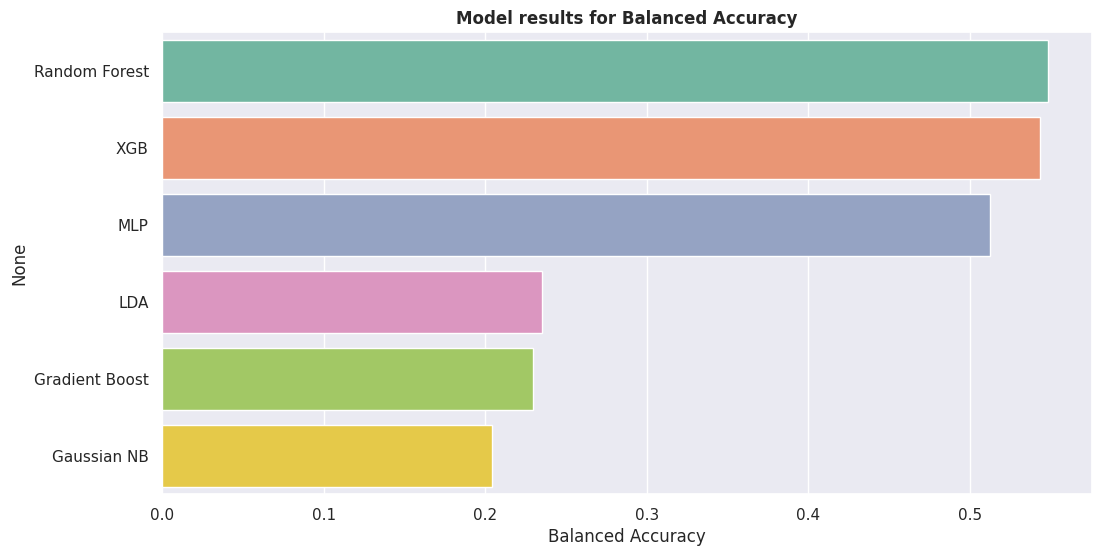

In [ ]:
names = [
    'Random Forest',
    'MLP',
    'Gradient Boost',
    'Gaussian NB',
    'LDA',
    'XGB'
]

results = pd.DataFrame(bal_acc_res, index=names)

results = results.set_axis(['Balanced Accuracy'], axis=1, copy=False).sort_values(by='Balanced Accuracy', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=results['Balanced Accuracy'], y=results.index, palette='Set2')
plt.title('Model results for Balanced Accuracy', weight='bold')

plt.show()

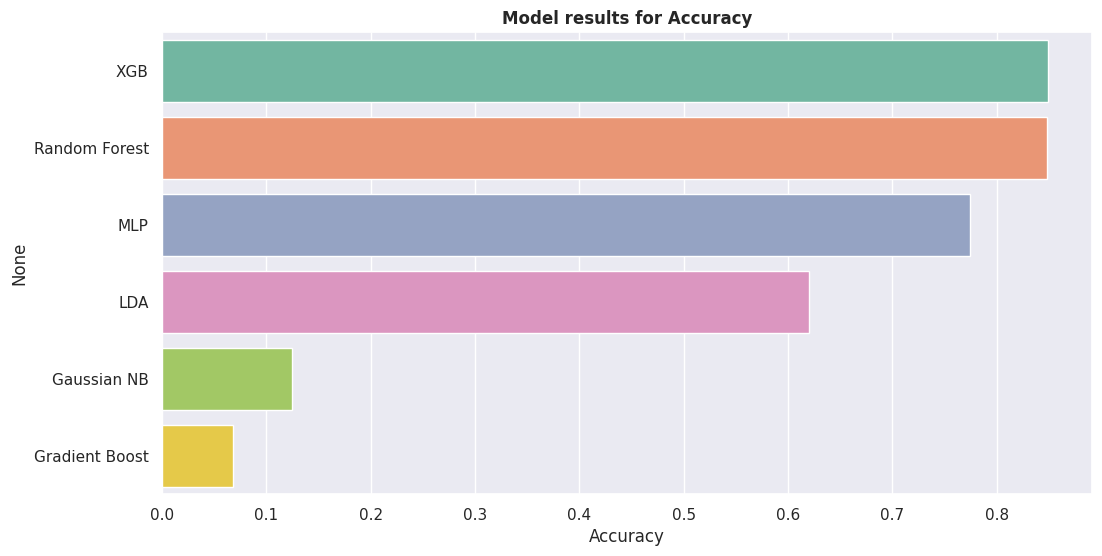

In [ ]:
results = pd.DataFrame(acc_res, index=names)

results = results.set_axis(['Accuracy'], axis=1, copy=False).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=results['Accuracy'], y=results.index, palette='Set2')
plt.title('Model results for Accuracy', weight='bold')


plt.show()

The out of box results show Random forest having both highest balanced accuracy (approx. 55%) and accuracy (approx. 85%)

Tune best model

In [ ]:
# Define model hyperparameter function
def tune_best_model(train_df: pd.DataFrame,
                    params: dict[str, Any],
                    drop_cols: list[str],
                    response: str = 'shiptype_encode',
                    group: str = 'mmsi',
                    scoring_metric: str = 'balanced_accuracy') -> dict[str, Any]:
    """Function to tune model and return best results and params

    Args:
        train_df (pd.DataFrame): Training data
        params (dict[str, Any]): Parameters to tune
        drop_cols (list[str]): Columns to drop
        response (str, optional): Response variable. Defaults to 'shiptype_encode'.
        group (str, optional): Variable to use for the grouped k-fold.
        Defaults to 'mmsi'.
        scoring_metric (str, optional): Performance metric. Defaults to 'balanced_accuracy'.

    Returns:
        dict[str, Any]: results dictionary
    """

    # Define groups for group k-fold
    groups = train_df[group]

    X = train_df.drop(drop_cols, axis=1)
    y = train_df[response]

    # Grouped 5-fold CV
    gkf = GroupKFold(n_splits=5)
    gkf.get_n_splits(X, y, groups)

    print(f"Tuning models for {response} with {len(train_df)} training rows")

    # Define sample weights since we are dealing with a significant imbalance between classes
    samp_weights = compute_sample_weight(class_weight='balanced', y=y)

    rf_cv = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=params,
        cv=gkf,
        verbose=10,
        scoring=scoring_metric,
    )

    rf_cv.fit(X, y, groups=groups, sample_weight=samp_weights)

    results = dict(
        {
            f"scores_{response}": rf_cv.best_score_,
            f"params_{response}": rf_cv.best_params_
        }
    )

    return results

In [ ]:
results

{'scores_shiptype_encode': 0.5041368273825764,
 'params_shiptype_encode': {'max_depth': 10, 'n_estimators': 100}}

In [ ]:
params = {'max_depth': [None, 4,5,6, 7, 8, 9, 10],
         'n_estimators': [50, 100, 200]}

results = tune_best_model(train_df, params=params, drop_cols=drop_cols)

Tuning models for shiptype_encode with 290507 training rows
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 1/5; 1/24] END max_depth=None, n_estimators=50;, score=0.566 total time=  26.1s
[CV 2/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 2/5; 1/24] END max_depth=None, n_estimators=50;, score=0.459 total time=  20.7s
[CV 3/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 3/5; 1/24] END max_depth=None, n_estimators=50;, score=0.514 total time=  17.2s
[CV 4/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 4/5; 1/24] END max_depth=None, n_estimators=50;, score=0.373 total time=  15.8s
[CV 5/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 5/5; 1/24] END max_depth=None, n_estimators=50;, score=0.432 total time=  16.1s
[CV 1/5; 2/24] START max_depth=None, n_estimators=100

In [ ]:
results

{'scores_shiptype_encode': 0.5041368273825764,
 'params_shiptype_encode': {'max_depth': 10, 'n_estimators': 100}}

Cross validation score with hyperparameters max depth:10 and n estimators:100 = Balanced accuracy 50.4%

Evaluate model with best hyperparameters on serving set

In [ ]:
best_params = {'max_depth': 10, 'n_estimators': 100}

In [ ]:
X = train_df.drop(drop_cols, axis=1)
y = train_df[response]

samp_weights = compute_sample_weight(class_weight='balanced', y=y)
mod = RandomForestClassifier(**best_params)
mod.fit(X, y, samp_weights)

RandomForestClassifier(max_depth=10)

In [ ]:
X_serving = serving_df.drop(drop_cols, axis=1)
y_serving = serving_df[response]

In [ ]:
preds = mod.predict(X_serving)

In [ ]:
probs = mod.predict_proba(X_serving)

In [ ]:
acc = accuracy_score(y_serving, preds)
bal_acc = balanced_accuracy_score(y_serving, preds)

print(f"Results on serving set, balanced accuracy={bal_acc}, accuraqcy={acc}")

Results on serving set, balanced accuracy=0.5704892830499785, accuraqcy=0.6389851412462559


In [ ]:
acc = accuracy_score(y_serving, preds)
bal_acc = balanced_accuracy_score(y_serving, preds)

print(f"Results on serving set, balanced accuracy={bal_acc}, accuraqcy={acc}")

Results on serving set, balanced accuracy=0.5704892830499785, accuraqcy=0.6389851412462559


Feature Importance

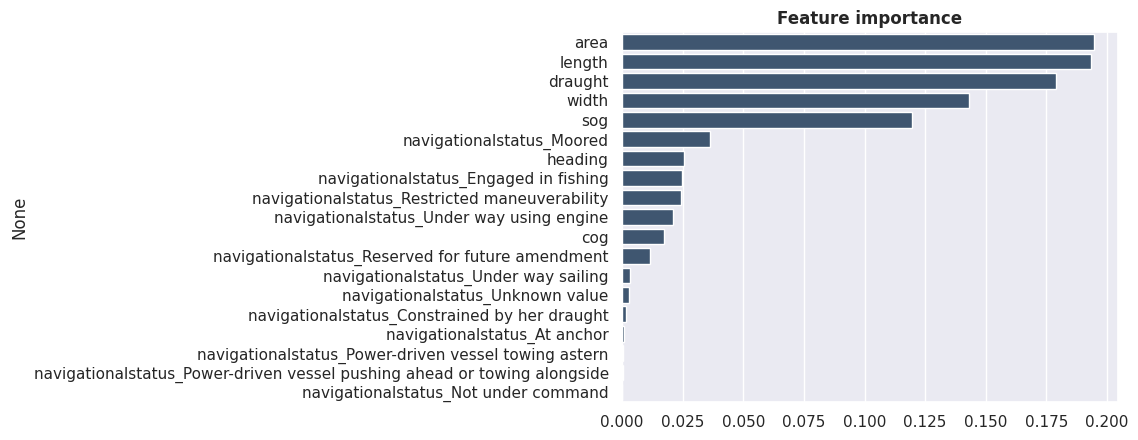

In [ ]:
# Extract feature importance
feat_imp = pd.Series(mod.feature_importances_, X.columns).sort_values(
    ascending=False
)
# # Remove columns which provide no benefit to the model
# feat_imp = feat_imp[feat_imp > 0.01]
feat_df = pd.DataFrame(feat_imp.values, feat_imp.index)

sns.barplot(x=feat_imp.values, y=feat_imp.index, color="#375578")
plt.title(f"Feature importance", weight="bold")
plt.show()

Additional validation is to understand how confident the model is predicting the classes

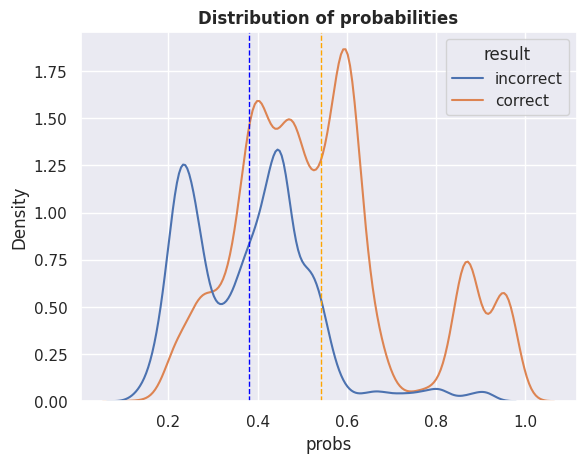

In [ ]:
results_df = pd.DataFrame(
            {
                "ground_truth": serving_df[response],
                "ground_truth_orig": serving_df['shiptype'],
                "pred": preds,
                "probs": [prob[pred] for (pred, prob) in zip(preds, probs)]
            }
        )

results_df['result'] = results_df.apply(lambda x: 'correct' if x.ground_truth==x.pred else 'incorrect', axis=1)

sns.kdeplot(data=results_df, x="probs", hue='result')
plt.axvline(results_df[results_df.result=='correct'].probs.mean(), c="orange", ls="--", lw=1)
plt.axvline(results_df[results_df.result=='incorrect'].probs.mean(), c="blue", ls="--", lw=1)
plt.title("Distribution of probabilities", weight="bold")
plt.show()

The above probability plot illustrates the distribution of probabilities for the predictions the model gets correct compared to the predictions it makes that are incorrect. The model is both predicting with high confidence as well as showing a significant difference between the ones it gets correct opposed to what it gets incorrect.

Lastly, get results for each class

In [ ]:
acc_list = list()

for ship in results_df.ground_truth_orig.unique():
    ship_res = results_df[results_df.ground_truth_orig==ship]
    acc = accuracy_score(ship_res.ground_truth, ship_res.pred)
    acc_list.append(acc)

    print(f"Results for {ship}, accuracy:{round(acc, 2)}, count:{len(ship_res)}")

Results for Cargo, accuracy:0.58, count:21876
Results for Military, accuracy:0.55, count:523
Results for Tanker, accuracy:0.75, count:9310
Results for HSC, accuracy:0.59, count:82
Results for Pilot, accuracy:1.0, count:480
Results for Passenger, accuracy:0.89, count:271
Results for Dredging, accuracy:0.78, count:673
Results for Fishing, accuracy:0.79, count:708
Results for Towing long/wide, accuracy:0.0, count:1
Results for Tug, accuracy:0.37, count:115
Results for Sailing, accuracy:0.0, count:15


In [ ]:
results

{'scores_shiptype_encode': 0.5041368273825764,
 'params_shiptype_encode': {'max_depth': 10, 'n_estimators': 100}}

In [ ]:
df

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3,1287.0
5,636020662,At anchor,0.1,43.9,286.0,Cargo,23.0,149.0,6.3,3427.0
7,246539000,At anchor,0.0,3.8,293.0,Cargo,16.0,150.0,6.8,2400.0
8,210307000,Moored,0.0,285.1,225.0,Cargo,16.0,90.0,5.2,1440.0
11,219263000,Moored,0.0,353.9,100.0,Military,12.0,48.0,4.2,576.0
...,...,...,...,...,...,...,...,...,...,...
358345,266475000,Under way using engine,11.2,92.4,90.0,Tanker,17.0,120.0,6.7,2040.0
358346,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2,984.0
358347,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9,4590.0
358348,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9,8064.0


In [ ]:
results = pd.DataFrame(acc_list, index=results_df.ground_truth_orig.unique())
results = results.set_axis(['Accuracy'], axis=1, copy=False).sort_values(by='Accuracy', ascending=False)

count_all = list()
count_serving = list()

for ship in results.index:
    count_all.append(len(df[df.shiptype==ship]))
    count_serving.append(len(results_df[results_df.ground_truth_orig==ship]))

results['count_all'] = count_all
results['count_serving'] = count_serving

results

,Accuracy,count_all,count_serving
Pilot,1.000000,2902,480
Passenger,0.885609,16778,271
Fishing,0.786723,12110,708
Dredging,0.775632,5109,673
Tanker,0.747046,77405,9310
HSC,0.585366,3694,82
Cargo,0.577208,186699,21876
Military,0.552581,6073,523
Tug,0.365217,9410,115
Towing long/wide,0.000000,586,1


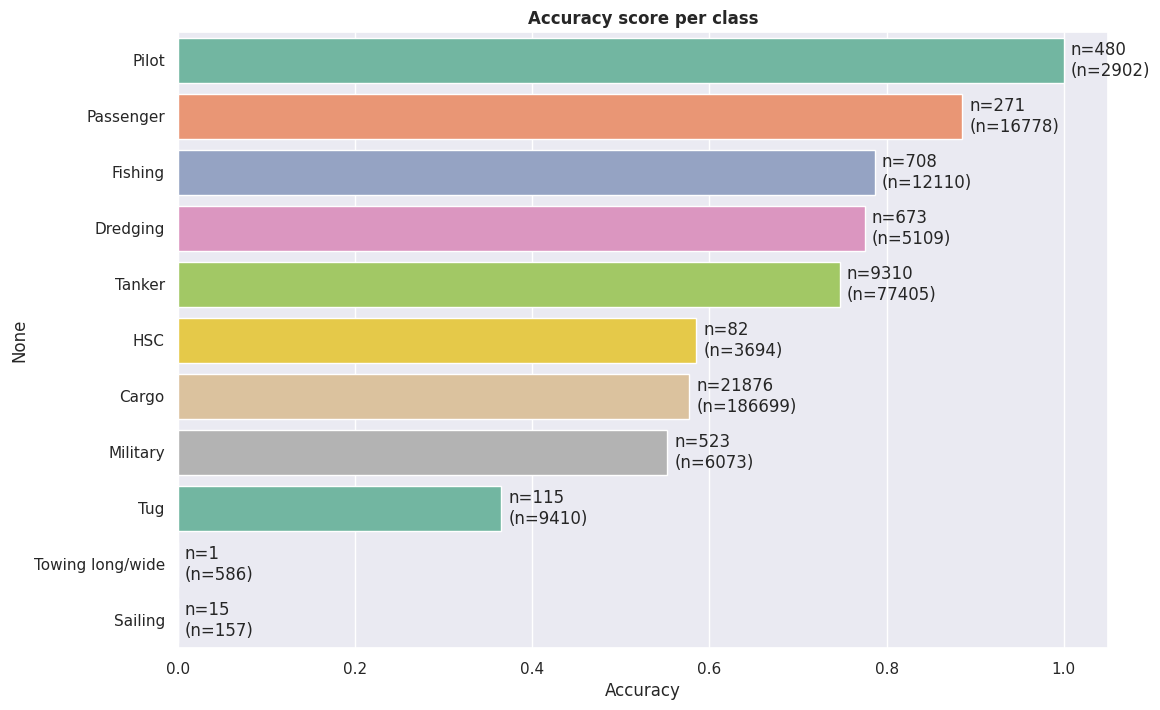

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=results['Accuracy'], y=results.index, palette='Set2')

for p, count, count_train in zip(ax.patches, results.count_serving,results.count_all):
    ax.annotate(f"n={count}\n(n={count_train})", xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.title('Accuracy score per class', weight='bold')

plt.show()